In [1]:
!pip install Unidecode

In [2]:
import ee
import time
import sys
from unidecode import unidecode
import argparse
import os.path
import matplotlib.pyplot as plt
import numpy as np
import cv2
from random import random
try:
    from google.colab.patches import cv2_imshow
except:
    from cv2 import imshow as cv2_imshow


In [3]:
#initialize google earth engine
try:
  ee.Initialize()
except:
  ee.Authenticate()
  ee.Initialize()

# Global variables

In [4]:
# name of GEE collections:
IMG_GEE = ['UMD/hansen/global_forest_change_2019_v1_7']
# !! The collection is an ee.Image dataset, not an ee.ImageCollection 

# Images codes -- description
IMG_GEE_CODES = ['forest_change']

# Bands that will be selected in each collection
IMG_GEE_BANDS = [['treecover2000','loss']]

# Ranges for plotting images (debug mode = True)                      
IMG_GEE_MIN = [0.0]
IMG_GEE_MAX = [100.0]
CLEAN_NAME = lambda r, l: unidecode(r.get('properties').get(l)).lower().translate("'()/&-").strip()

# Functions

In [5]:
def export_to_cloud(img, fname, folder, expregion, eeuser=None, scale=10):
  task = ee.batch.Export.image.toDrive(**{
      'image': img.clip(expregion),
      'description':fname, 
      'folder':folder, 
      'fileNamePrefix':fname, 
      'dimensions':None, 
      'region':expregion.geometry().bounds().getInfo()['coordinates'],
      'scale':scale, 
      'crs':'EPSG:4326', 
      'crsTransform':None, 
      'maxPixels':1e13
  })
  task.start()
  while task.status()['state'] == 'RUNNING':
    print('Running...')
    time.sleep(20)
  print('Done.'.format(task.status()))
  time.sleep(10)

In [11]:
def export_ee_image(ftr_collection, boundary_filter, ee_image_name, folder_name_drive, only_download_first_image=True, debug=False, scale=100):
    # Get Shapefile features into a list 
    county_region = ee.FeatureCollection(ftr_collection)
    feature_list = county_region.toList(1e5)
    feature_list_computed = feature_list.getInfo()

    # Get ee Image 
    img_index = IMG_GEE_CODES.index(ee_image_name)
    ee_image = IMG_GEE[img_index]
    img = ee.Image(ee_image) 

    for idx, region in enumerate(feature_list_computed):
      subunit_key = ftr_key_fn(region)

      # Plot images being dowloaded (for each departments)
      if debug:
        for i in range(1):
          bands = IMG_GEE_BANDS[img_index][0] #visualize only first band
          plotROI(img, ee.Feature(region),debug=debug, 
                  bands=bands, max=IMG_GEE_MAX[img_index])
          
      file_name = country + '_' + ee_image_name + '_' + subunit_key 
      print(file_name)
      print(idx)
      folder_name = os.path.join(folder_name_drive, ee_image_name)
      export_to_cloud(img, file_name, folder_name, ee.Feature(region), scale=scale)

      if only_download_first_image:
        break #only first image 

In [7]:
# Visualize ROI (Region of interest) -- Works for Landsat; Issue with Sentinal

def plotROI(image,roi, debug = False, bands = ['B4', 'B3', 'B2'], max = 0.5):
  url = image.getThumbURL({
  'bands': bands,
  'min':0,
  'max':max,
  'region': roi
  })
  fname = "RGB_"+str(random()).split('.')[1]+".png"

  status = os.system(f"""wget -O "{fname}" -c --read-timeout=5 --tries=0 "{url}" """)

  if (not status):
    if debug: 
      print("File name:", fname)
      img = cv2.imread(fname)
      cv2_imshow(img)
  return fname

# GEE 

In [8]:
country = 'senegal'
folder_name_drive = "Senegal_modis"

# rough rectangle around senegal to help GEE focus on this area
boundary_filter = [-17.891849582500733,12.010217171292826, -10.83862692625073,16.776053324382982]

# using shapefile from https://gadm.org/ level 2 is departments
ftr_collection = 'users/margauxmasson21/SEN2'

ftr_key_fn = lambda region: CLEAN_NAME(region, 'NAME_1') + "-" +  CLEAN_NAME(region,'NAME_2') # SN: "<zone name>-<state name>"]

##### IF YOU WANT TO DOWNLOAD DAT FOR ANOTHER COUNTRY CHANGE THE PARAMETERS ABOVE ########
ftr_filter_fn = lambda region: True


# Export images to Drive 

File name: RGB_7164903999145227.png


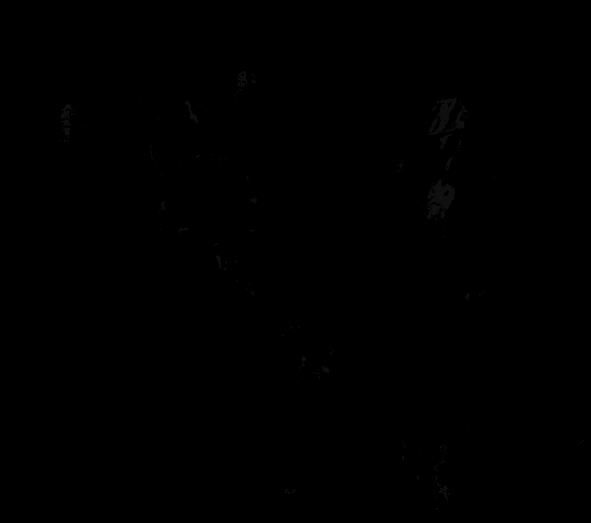

senegal_forest_change_dakar-dakar
0
Done.


In [12]:
eeImage_name = 'forest_change'
export_ee_image(ftr_collection, boundary_filter, 
                         eeImage_name, 
                         folder_name_drive, 
                         only_download_first_image=True, # change this to False if downaloading all images 
                         debug=True, 
                         scale=150)